In [1]:
# necessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.metrics import *

import scipy.sparse as sparse

from sklearn.feature_selection import RFE
import tqdm

from sklearn.utils.class_weight import compute_class_weight 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
df = pd.read_csv('../../Data/final_df.csv', usecols = ['Sequence', 'Qualitative_Measure'])

In [3]:
df

,Sequence,Qualitative_Measure
0,DRAHYNIVTFCCKCD,Positive
1,MHGDTPTLHEYM,Positive
2,DSTLRLCVQSTHVD,Positive
3,RNGYRALMDKSLHVGTQCALTRR,Positive
4,SYVLEGTLTAEKTTLVVKEG,Positive
...,...,...
11420,AFMGYALPWGQMSFWGATVI,Negative
11421,QKLAPISIMYQISPPLNVSL,Positive
11422,SCSPTFSSDPLTTPPLMLTT,Negative
11423,PLPWALQTTNLPLMAMSSLL,Positive


## First, we will be trying to select the ngram size to work with
I am working with LogisticRegression Model for this since it is a simple model to work with and hence would consume less memory during this iterative process

In [6]:
# hyperparameter tuning for n_grams and C
def nlp_tuning(n_grams, df):
    fig, ax = plt.subplots(n_grams, figsize=(16,35))
    
    for i in tqdm.tqdm(range(1,n_grams+1)):
        vect = CountVectorizer(ngram_range=(1,i), analyzer='char', min_df=1)
        df_nlp = vect.fit_transform(df['Sequence'])

        X_train, X_test, y_train, y_test = train_test_split(df_nlp, df['Qualitative_Measure'], train_size=0.8, stratify = df['Qualitative_Measure'], random_state=42)
        
        classes = np.unique(y_train.to_numpy()) 
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train) 
        class_weights = dict(zip(classes, weights)) 
        
        mcc_train = []
        mcc_val = []
    
        for c in np.logspace(-3, 2, 50):
            logreg = LogisticRegression(C=c, class_weight=class_weights)

            logreg.fit(X_train, y_train)
    
            mcc_train.append(matthews_corrcoef(y_train, logreg.predict(X_train)))
    
            mcc_val.append(matthews_corrcoef(y_test, logreg.predict(X_test)))
        
        ax[i-1].plot([i for i in np.logspace(-3, 2, 50)], mcc_train, label='Train', color='r', linewidth=1.5, linestyle='--')
        ax[i-1].plot([i for i in np.logspace(-3, 2, 50)], mcc_val, label='Val', color='g', linewidth=3)
        ax[i-1].set_xlabel('C')
        ax[i-1].set_ylabel('MCC')
        ax[i-1].set_title(f'n-grams{i}')
        ax[i-1].grid(alpha=0.6, color='k', linestyle='--')
        ax[i-1].set_xscale('log')
        

100%|███████████████████████████████████████████| 10/10 [12:58<00:00, 77.85s/it]


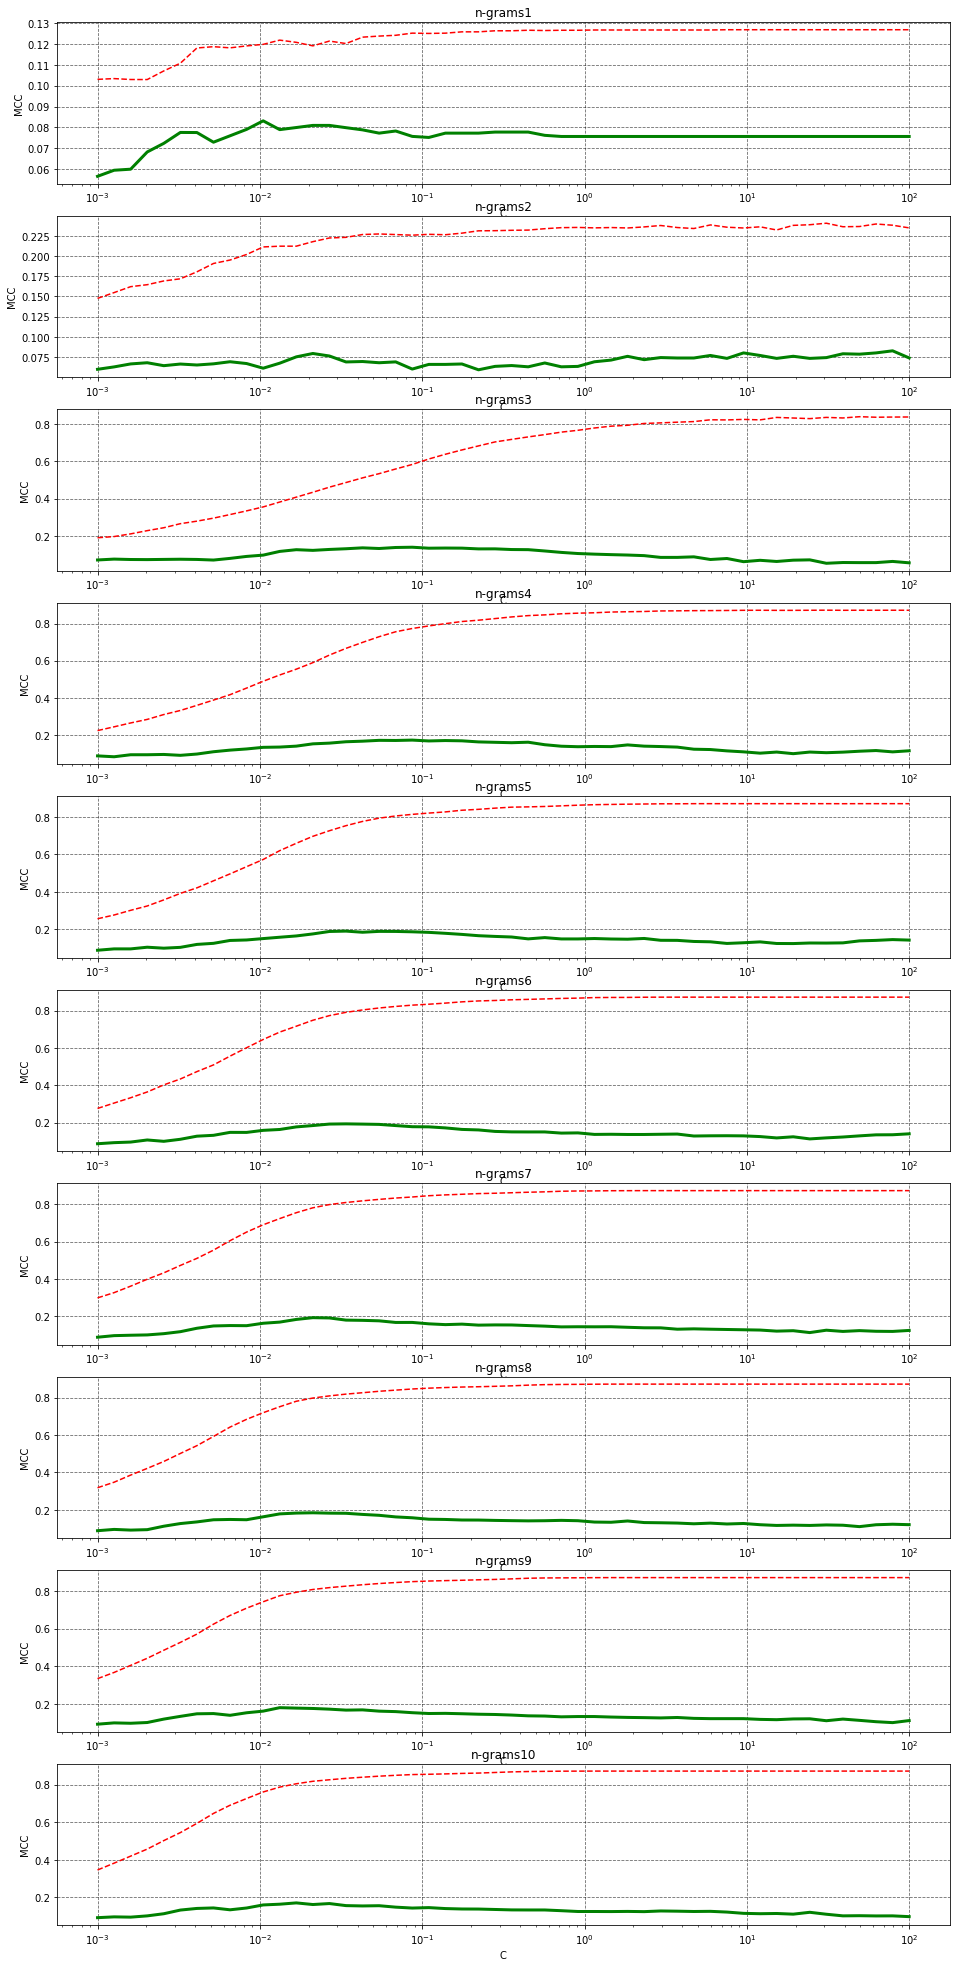

In [7]:
nlp_tuning(10, df)

Based on the training and validation MCC scores recieved, working with ngrams = 3 or 4 would be the best. n-grams value lower than this are not yielding as good of results and ngrams more than this are giving decent results but the dimensionality will be too high which we want to avoid. Thus, n-grams = 3 should be a safe bet.

Also, we will be working with C=0.1 for the LogisticRegression models

In [45]:
# hyperparameter tuning for n_grams and min_df
def nlp_tuning(n_grams,min_df, df):
    scaler = MaxAbsScaler()
    fig, ax = plt.subplots(n_grams, figsize=(16,35))
    
    for i in tqdm.tqdm(range(1,n_grams+1)):
        mcc_train = []
        mcc_val = []
        for j in range(1,min_df+1,2):
            vect = CountVectorizer(ngram_range=(1,i), analyzer='char', min_df=j)
            df_nlp = vect.fit_transform(df['Sequence'])
            print(df_nlp.shape)
            X_train, X_test, y_train, y_test = train_test_split(df_nlp, df['Qualitative_Measure'], train_size=0.8, stratify = df['Qualitative_Measure'], random_state=42)
    
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            classes = np.unique(y_train.to_numpy()) 
            weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train) 
            class_weights = dict(zip(classes, weights)) 
    
            logreg = LogisticRegression(class_weight=class_weights)

            logreg.fit(X_train_scaled, y_train)
    
            mcc_train.append(matthews_corrcoef(y_train, logreg.predict(X_train_scaled)))
    
            mcc_val.append(matthews_corrcoef(y_test, logreg.predict(X_test_scaled)))

        ax[i-1].plot(range(1,min_df+1,2), mcc_train, label='Train', color='r', linewidth=1.5, linestyle='--')
        ax[i-1].plot(range(1,min_df+1,2), mcc_val, label='Val', color='g', linewidth=3)
        ax[i-1].set_xlabel('min_df')
        ax[i-1].set_ylabel('MCC')
        ax[i-1].set_title(f'n-grams={i}')
        ax[i-1].grid(alpha=0.6, color='k', linestyle='--')
        ax[i-1].legend()

  0%|                                                     | 0/5 [00:00<?, ?it/s]

(11425, 20)
(11425, 20)
(11425, 20)
(11425, 20)
(11425, 20)
(11425, 20)


 20%|█████████                                    | 1/5 [00:00<00:02,  1.46it/s]

(11425, 20)
(11425, 20)
(11425, 420)
(11425, 420)
(11425, 420)
(11425, 420)
(11425, 420)
(11425, 420)
(11425, 420)
(11425, 420)


 40%|██████████████████                           | 2/5 [00:02<00:03,  1.13s/it]

(11425, 7985)
(11425, 7326)
(11425, 6698)
(11425, 6103)
(11425, 5513)
(11425, 5057)
(11425, 4624)


 60%|███████████████████████████                  | 3/5 [00:04<00:03,  1.84s/it]

(11425, 4186)
(11425, 58569)
(11425, 26264)
(11425, 14184)
(11425, 9447)
(11425, 7216)
(11425, 5997)
(11425, 5172)


 80%|████████████████████████████████████         | 4/5 [00:08<00:02,  2.74s/it]

(11425, 4511)
(11425, 130324)
(11425, 37296)
(11425, 16633)
(11425, 10379)
(11425, 7659)
(11425, 6217)
(11425, 5280)


100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]

(11425, 4566)


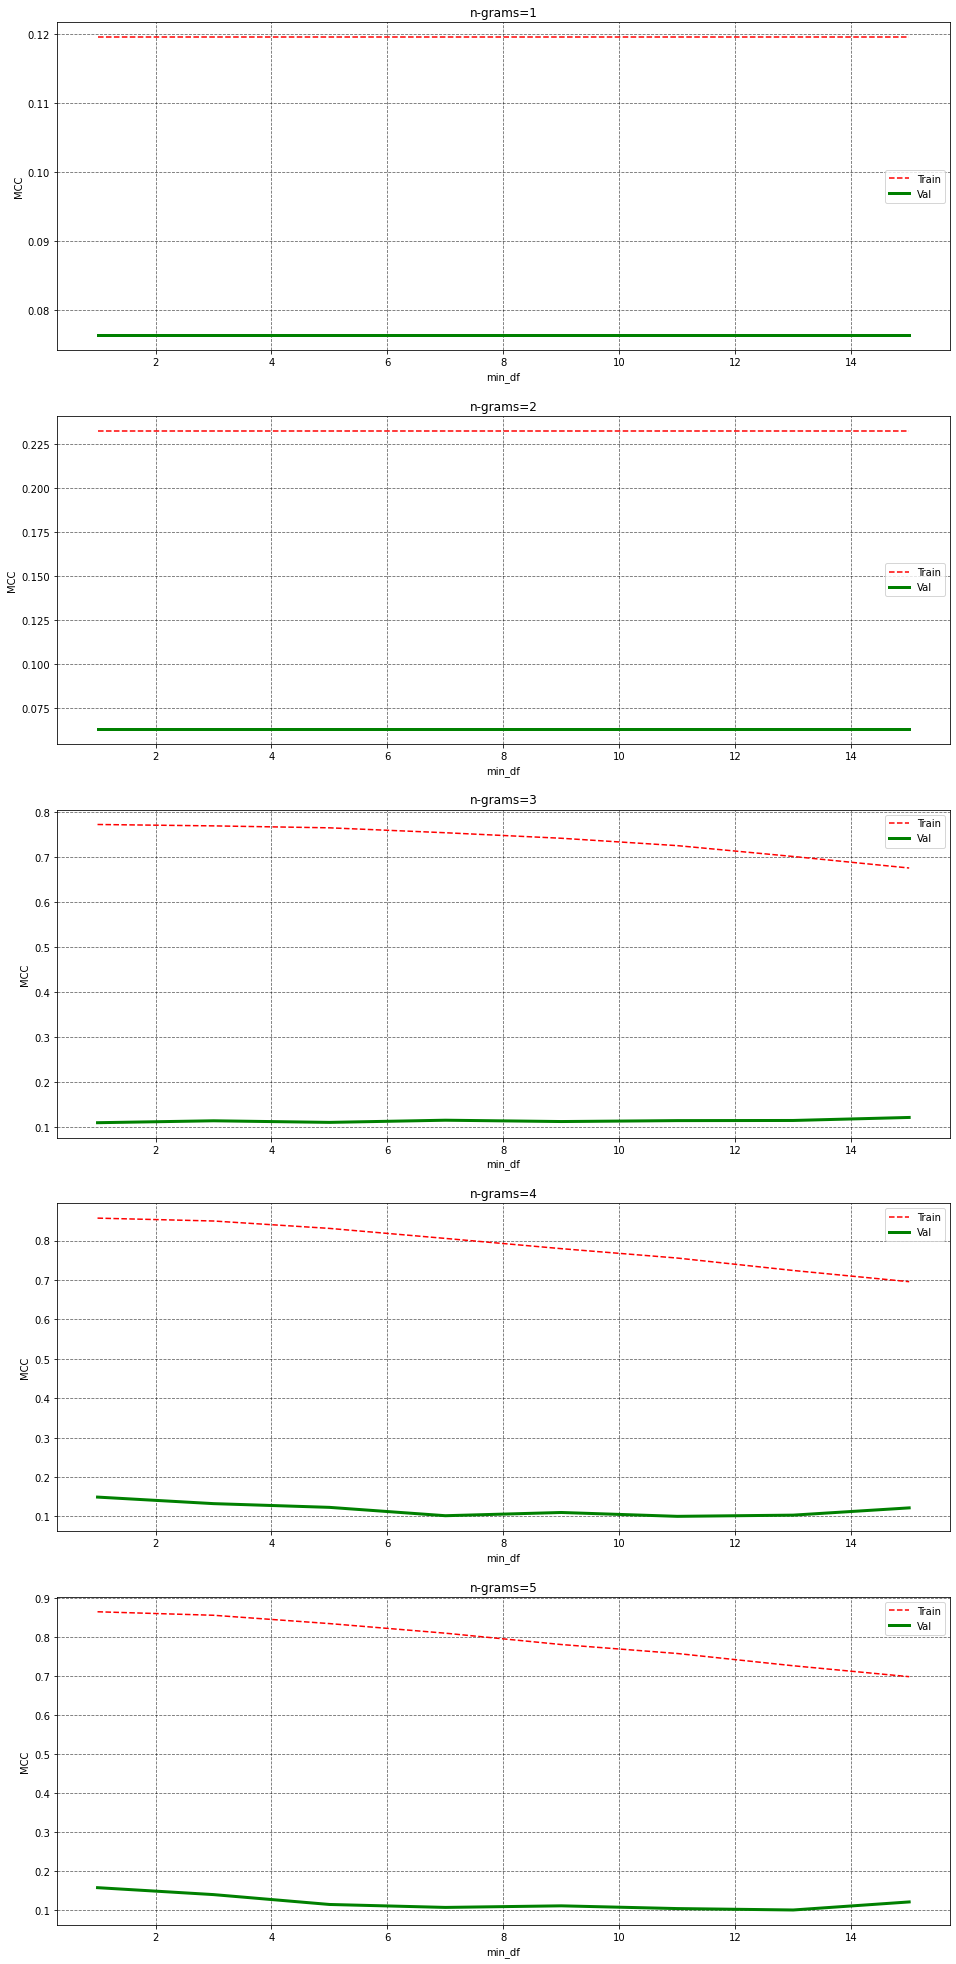

In [46]:
nlp_tuning(5,15,df)

### How come the df_nlp is being made inconsistent number of times, it should have been built 8 times always, for each min_df value from 1->15

### Let's first construct a "bag-of-words" vector dataframe for the purpose of Machine Learning
> n-grams range will be 1-3 as decided earlier

> we want to consider each individual amino acid as a token of information instead of the entire peptide sequence as one token and hence will be analysing a "character"

In [4]:
# converting our sequence data into matrix of tokens
vect = CountVectorizer(ngram_range=(1, 3), analyzer='char', min_df=1)
df_nlp = vect.fit_transform(df['Sequence'])

In [5]:
df_nlp

<11425x7985 sparse matrix of type '<class 'numpy.int64'>'
	with 417622 stored elements in Compressed Sparse Row format>

## 1. Training model on all the features

In [6]:
X = df_nlp   # training on sparse matrix so that train time is very less
y = df['Qualitative_Measure']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y, random_state=42)

scaler = MaxAbsScaler() # since other scalers dont work on sparse matrix

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9140, 7985), (2285, 7985), (9140,), (2285,))

In [8]:
# oversampling the data to remove imbalance
oversampler = SMOTE(random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

X_train_scaled_os = scaler.fit_transform(X_train_os)
X_test_scaled_os = scaler.transform(X_test)

In [9]:
# computing class weights to deal with class imbalance
classes = np.unique(y_train.to_numpy())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights)) 

In [10]:
class_weights

{'Negative': 0.6584065696585506, 'Positive': 2.078217371532515}

In [11]:
# making our own scorer function for GridSearchCV
def matthews_correlation(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    mcc = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    
    return mcc

mcc = make_scorer(matthews_correlation, greater_is_better=True)

### 1.Logistic Regression

**1.1 with default parameters**

In [12]:
# using class weights to deal with the class imbalance
logreg = LogisticRegression(C = 0.1, class_weight=class_weights)

logreg.fit(X_train_scaled, y_train)

# evaluating the performance
print(f"Confusion matrix:\n {confusion_matrix(y_test, logreg.predict(X_test_scaled))}")
print(f"MCC score: {matthews_corrcoef(y_test, logreg.predict(X_test_scaled))}")

Confusion matrix:
 [[1220  515]
 [ 296  254]]
MCC score: 0.1492695509167084


In [13]:
# using oversampling for balancing the classes
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_scaled_os, y_train_os)

# evaluating the performance
print(f"Confusion matrix:\n {confusion_matrix(y_test, logreg.predict(X_test_scaled_os))}")
print(f"MCC score: {matthews_corrcoef(y_test, logreg.predict(X_test_scaled_os))}")

Confusion matrix:
 [[1427  308]
 [ 409  141]]
MCC score: 0.08482606716796119


Using class weights for dealing with class imbalance is giving better results.

**1.2 Using GridSearchCV for parameter tuning**

In [14]:
# let's use gridsearchcv for the best parameter and also to look at the cross validation performance
# using class weights
param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

logreg = LogisticRegression(class_weight=class_weights, max_iter=1000)

stratified_fold = StratifiedKFold()

gridlr1 = GridSearchCV(logreg, param_grid_lr, cv = stratified_fold, n_jobs=-1, scoring=mcc, return_train_score=True)

gridlr1.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight={'Negative': 0.6584065696585506,
                                                        'Positive': 2.078217371532515},
                                          max_iter=1000),
             n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [15]:
pd.DataFrame(gridlr1.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
4,{'C': 0.1},0.650077,0.149081
3,{'C': 0.01},0.450249,0.149061
2,{'C': 0.001},0.350171,0.140281
1,{'C': 0.0001},0.333562,0.139442
5,{'C': 0.3},0.745084,0.134934
6,{'C': 0.5},0.779097,0.131527
7,{'C': 0.7},0.799073,0.125832
8,{'C': 1},0.815527,0.121817
0,{'C': 1e-05},0.284630,0.118115


In [16]:
# saving the best model
modellr1 = gridlr1.best_estimator_
modellr1

LogisticRegression(C=0.1,
                   class_weight={'Negative': 0.6584065696585506,
                                 'Positive': 2.078217371532515},
                   max_iter=1000)

In [17]:
# evaluating the performance
print(f"Confusion matrix:\n {confusion_matrix(y_test, modellr1.predict(X_test_scaled))}")
print(f"MCC score: {matthews_corrcoef(y_test, modellr1.predict(X_test_scaled))}")

Confusion matrix:
 [[1220  515]
 [ 296  254]]
MCC score: 0.1492695509167084


In [18]:
# using oversampled balanced dataset to train
param_grid_lr = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]}

logreg = LogisticRegression(max_iter=1000)

stratified_fold = StratifiedKFold()

gridlr2 = GridSearchCV(logreg, param_grid_lr, cv = stratified_fold, n_jobs=-1, scoring=mcc, return_train_score=True)

gridlr2.fit(X_train_scaled_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7,
                               1]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [19]:
pd.DataFrame(gridlr2.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

,params,mean_train_score,mean_test_score
3,{'C': 0.01},0.713985,0.655342
4,{'C': 0.1},0.783931,0.649041
2,{'C': 0.001},0.678071,0.630868
5,{'C': 0.3},0.833043,0.624427
1,{'C': 0.0001},0.670102,0.624218
0,{'C': 1e-05},0.668599,0.622298
6,{'C': 0.5},0.856882,0.611064
7,{'C': 0.7},0.873150,0.603190
8,{'C': 1},0.889740,0.595601


In [20]:
# saving the best model
modellr2 = gridlr2.best_estimator_
modellr2

LogisticRegression(C=0.01, max_iter=1000)

In [21]:
# evaluating the performance
print(f"Confusion matrix:\n {confusion_matrix(y_test, modellr2.predict(X_test_scaled_os))}")
print(f"MCC score: {matthews_corrcoef(y_test, modellr2.predict(X_test_scaled_os))}")

Confusion matrix:
 [[1639   96]
 [ 494   56]]
MCC score: 0.07975230272030406


So, we see that overall, LR give better results on providing it with class weights rather than an oversampled balanced data.

### 2. Naive Bayes

In [22]:
# training the model
nb = MultinomialNB()

nb.fit(X_train, y_train)

# testing the performance
print(f"Confusion matrix for NB:\n {confusion_matrix(y_test, nb.predict(X_test))}")
print(f"MCC score for NB: {matthews_corrcoef(y_test, nb.predict(X_test))}")

Confusion matrix for NB:
 [[1402  333]
 [ 364  186]]
MCC score for NB: 0.14922818192270978


### 3. SVM

In [35]:
# training the model
svc = SVC(class_weight=class_weights, probability=True)

param_grid_svc = {'C':[0.1,10,100],
              'gamma':[0.001,0.01,0.1,10,100]}

gridsvc = GridSearchCV(svc, param_grid_svc, scoring=mcc, n_jobs=-1, cv=stratified_fold, return_train_score=True)

gridsvc.fit(X_train_scaled, y_train)

/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_13496/2626833026.py:5: RuntimeWarni

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight={'Negative': 0.6584065696585506,
                                         'Positive': 2.078217371532515},
                           probability=True),
             n_jobs=-1,
             param_grid={'C': [0.1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 10, 100]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [36]:
pd.DataFrame(gridsvc.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
5,"{'C': 10, 'gamma': 0.001}",0.517417,0.152136
6,"{'C': 10, 'gamma': 0.01}",0.806541,0.144865
10,"{'C': 100, 'gamma': 0.001}",0.746499,0.140635
11,"{'C': 100, 'gamma': 0.01}",0.892798,0.091669
7,"{'C': 10, 'gamma': 0.1}",0.895588,0.059646
12,"{'C': 100, 'gamma': 0.1}",0.895835,0.058866
2,"{'C': 0.1, 'gamma': 0.1}",0.178710,0.036393
8,"{'C': 10, 'gamma': 10}",0.895835,-0.119522
9,"{'C': 10, 'gamma': 100}",0.895835,-0.119522
13,"{'C': 100, 'gamma': 10}",0.895835,-0.119522


In [37]:
modelsvc = gridsvc.best_estimator_
modelsvc

SVC(C=10,
    class_weight={'Negative': 0.6584065696585506,
                  'Positive': 2.078217371532515},
    gamma=0.001, probability=True)

In [38]:
# evaulating model performance
print(f"Confusion matrix for SVC:\n {confusion_matrix(y_test, modelsvc.predict(X_test_scaled))}")
print(f"Matthews correlation coefficient for SVC: {matthews_corrcoef(y_test, modelsvc.predict(X_test_scaled))}")

Confusion matrix for SVC:
 [[1193  542]
 [ 287  263]]
Matthews correlation coefficient for SVC: 0.14837486023660676


### 4. RandomForestClassifier

In [28]:
# training the model with default parameters
rfc = RandomForestClassifier()

rfc.fit(X_train_os, y_train_os)

# evaluating the performance
matthews_corrcoef(y_test, rfc.predict(X_test))

0.07716410130972995

In [29]:
# let's use gridsearchcv for the best parameter and also to look at the cross validation performance
rfc = RandomForestClassifier()

param_grid_rfc = {'n_estimators':[100,200,300,400,500,600,1000],
                  'max_depth':[3,5,7],
                  'max_features':[0.5,0.6,0.7,0.8,0.9]}

gridrfc = GridSearchCV(rfc, param_grid_rfc, scoring=mcc, n_jobs=-1, cv=stratified_fold, return_train_score=True)

gridrfc.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 1000]},
             return_train_score=True,
             scoring=make_scorer(matthews_correlation))

In [30]:
pd.DataFrame(gridrfc.cv_results_)[['params','mean_train_score','mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
74,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.488719,0.417966
72,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.491473,0.416370
71,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.490142,0.413047
76,"{'max_depth': 7, 'max_features': 0.5, 'n_estim...",0.490514,0.412149
83,"{'max_depth': 7, 'max_features': 0.6, 'n_estim...",0.486061,0.411710
...,...,...,...
28,"{'max_depth': 3, 'max_features': 0.9, 'n_estim...",0.274252,0.264117
31,"{'max_depth': 3, 'max_features': 0.9, 'n_estim...",0.273463,0.263990
34,"{'max_depth': 3, 'max_features': 0.9, 'n_estim...",0.272938,0.263904
21,"{'max_depth': 3, 'max_features': 0.8, 'n_estim...",0.277348,0.263505


In [31]:
# saving the best model
modelrfc = gridrfc.best_estimator_
modelrfc

RandomForestClassifier(max_depth=7, max_features=0.5, n_estimators=500)

In [32]:
# evaulating model performance
print(f"Confusion matrix for RFC:\n {confusion_matrix(y_test, modelrfc.predict(X_test))}")
print(f"Matthews correlation coefficient for RFC: {matthews_corrcoef(y_test, modelrfc.predict(X_test))}")

Confusion matrix for RFC:
 [[1242  493]
 [ 379  171]]
Matthews correlation coefficient for RFC: 0.02519586256613227


## AU-ROC for all the models

In [39]:
print(f"AU-ROC score for LR is: {roc_auc_score(y_test, modellr1.predict_proba(X_test_scaled)[:,1])}")
print(f"AU-ROC score for NB is: {roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])}")
print(f"AU-ROC score for SVC is: {roc_auc_score(y_test, modelsvc.predict_proba(X_test_scaled)[:,1])}")
print(f"AU-ROC score for RFC is: {roc_auc_score(y_test, modelrfc.predict_proba(X_test)[:,1])}")

AU-ROC score for LR is: 0.6067503274823159
AU-ROC score for NB is: 0.5924448519779932
AU-ROC score for SVC is: 0.5950856693738538
AU-ROC score for RFC is: 0.5260717841236573


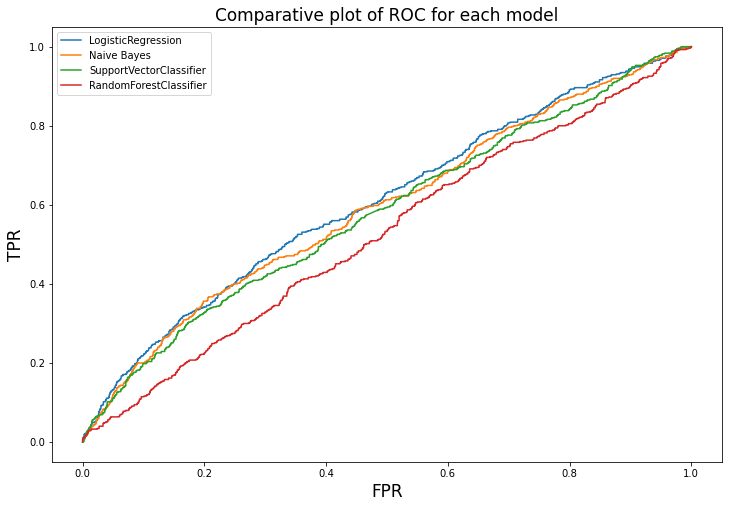

In [94]:
# plotting the ROCs for each model
fpr1, tpr1, threshold1 = roc_curve(y_test, modellr1.predict_proba(X_test_scaled)[:,1], pos_label='Positive')
fpr2, tpr2, threshold2 = roc_curve(y_test, nb.predict_proba(X_test)[:,1], pos_label='Positive')
fpr3, tpr3, threshold3 = roc_curve(y_test, modelsvc.predict_proba(X_test)[:,1], pos_label='Positive')
fpr4, tpr4, threshold4 = roc_curve(y_test, modelrfc.predict_proba(X_test)[:,1], pos_label='Positive')

plt.figure(figsize=(12,8))
plt.plot(fpr1,tpr1,label='LogisticRegression')
plt.plot(fpr2,tpr2,label='Naive Bayes')
plt.plot(fpr3,tpr3,label='SupportVectorClassifier')
plt.plot(fpr4,tpr4,label='RandomForestClassifier')

plt.xlabel('FPR', fontsize=17)
plt.ylabel('TPR', fontsize=17)
plt.title('Comparative plot of ROC for each model', fontsize=17)

plt.legend()
plt.show()

**All the models have quite the similar ROC, but RFC seems to be the most random in its predictions**

### <font color='palevioletred'>CONCLUSION</font>

Out of all RFC has the worst performance probably because it is a complex model and thus overfits quite a bit to the training data.

But again if we consider the performances of all the models it, all of them are overfitting and giving quite a poor performance on the test dataset. This can just mean that there is again not much distinguishing information even in the sequence of the IL-5 inducing and IL-5 non-inducing peptides.

We can try to reduce the dimensionality using RFE to see whether the performance for these models gets improved in any way.